In [18]:
from erddapy import ERDDAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':15})
import seaborn as sns
import config
from data_functions import *

## Background (from Mikelle and Amanda)

## Step 1: Load Data

The OOI Data Explorer contains over hundreds of datasets compiled across 9 arrays. We will be focusing on two locations, Station Pioneer and Station Irminger. (add photo of stations here)

These two stations have biotic and abiotic measurements from different measurements. To analyze the patterns of productivity, we will use time series of chlorophyll data from 2019-2023. In addition, we will use measurements of temperature, light, and nitrate to explore the controllers and relationships of chlorophyll. You can check out these datasets at the following websites: 

Each dataset has an associated table ID to easily pull it from the database. We will be using the variables from each of the stations described in the table below. The associated table IDs are also provided so that you can check out all the available variables for each instrument on the [ERDDAP page](https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/). 


| Station | Variable | ID |
| --- | --- | --- | 
| Pioneer | Chlorophyll and Temperature | ooi-cp04ossm-rid27-02-flortd000 |
| Pioneer | Light | ooi-cp01cnsm-sbd11-06-metbka000 |
| Pioneer | Nitrate | ooi-cp01cnsm-rid26-07-nutnrb000 |
| Irminger | Chlorophyll and Temperature | ooi-gi01sumo-sbd12-02-flortd000 |
| Irminger | Light | ooi-gi01sumo-sbd12-06-metbka000 |
| Irminger | Nitrate | ooi-gi01sumo-sbd11-08-nutnrb000 |

#### Run the following cell to read in our data:

In [ ]:
# load all data
all_chl, all_no3, all_light = load_data()


ooi-cp04ossm-rid27-02-flortd000
['time', 'mass_concentration_of_chlorophyll_a_in_sea_water', 'sea_water_temperature']
ooi-cp01cnsm-rid26-07-nutnrb000
['time', 'mole_concentration_of_nitrate_in_sea_water_suna', 'mole_concentration_of_nitrate_in_sea_water_suna_qc_agg']
ooi-cp01cnsm-sbd11-06-metbka000
['time', 'netsirr']


In [4]:
# search = 'chlorophyll pioneer mooring'
# search_url = e.get_search_url(search_for = search)
# df = pd.read_csv(search_url)
# df[['Dataset ID','Title','Summary']]

## Learning Objective 1:
Plot pioneer and irminger data as time series

Add instructions in markdown/prompts in code

Consider plot of interannual (seasonal) variations

In [17]:
# create interactive plot with ipywidgets 
from ipywidgets import widgets
import altair as alt
import datetime as dt

# Determine global axis limits
time_domain = [all_chl['time'].min(), all_chl['time'].max()]
chl_domain = [all_chl['chl'].min(), all_chl['chl'].max()+1]

# Create selection interval
date_range = (dt.date(2021, 1, 1), dt.date(2022, 1, 1))
brush = alt.selection_interval(encodings=['x'], value={'x': date_range})

# keep colors consistent per station
color_scale = alt.Scale(domain=['Pioneer', 'Irminger'], range=['#1f77b4', '#ff7f0e'])

# Define interactive function
def plot_time_series(station='All'):
    # set font sizes
    base = alt.Chart(all_chl).mark_point().encode(
        x=alt.X('time:T', scale=alt.Scale(domain=time_domain), title='Time'),
        y=alt.Y('chl:Q', scale=alt.Scale(domain=chl_domain), title='Chlorophyll-a Concentration (µg/L)'),
        color=alt.Color('station:N', scale=color_scale),
        tooltip=['time:T', 'chl:Q', 'station:N']
    ).properties(
        width=800,
        height=500
    )

    if station != 'All':
        base = base.transform_filter(alt.datum.station == station)

    upper = base.encode(alt.X('time:T').scale(domain=brush))

    lower = base.properties(
        height=60
    ).add_params(brush)
    
    display(upper & lower)

# Create dropdown widget
station_selector = widgets.Dropdown(
    options=['All'] + list(all_chl['station'].unique()),
    description='Station:',
    continuous_update=False
)
# Display interactive widget
display(widgets.interactive(plot_time_series, station=station_selector))

interactive(children=(Dropdown(description='Station:', options=('All', 'Pioneer', 'Irminger'), value='All'), O…

## Background

# Learning Objective #2
How do Temperature, Light, and Nitrate change with Chlorophyll?


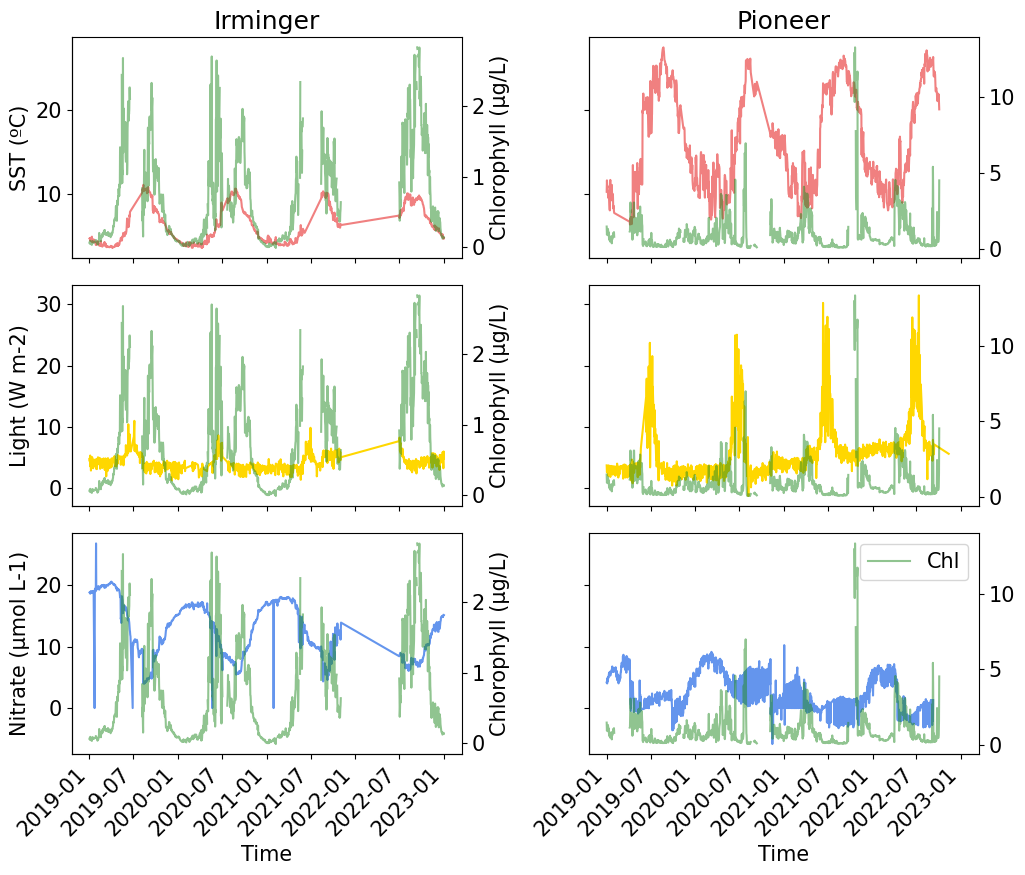

In [15]:
# merge datasets together
chl_light_df = pd.merge(all_chl, all_light, how='outer')
all_df = pd.merge(chl_light_df, all_no3, how='outer')
# melt wide to long
all_df_long = pd.melt(all_df, id_vars=['time', 'station', 'chl'], value_vars=['sst', 'light', 'no3'], var_name = 'measurement', value_name  = 'value')

# plot
g = sns.FacetGrid(all_df_long, row='measurement', col='station', hue='measurement', sharey='row', height=3, aspect=1.75)
g.map(sns.lineplot, 'time', 'value')

# custom colors (irradiance: puke yellow, temp: dark pink/light red, nitrate: blue, chl: green)
colors= ['lightcoral','lightcoral','gold','gold','cornflowerblue','cornflowerblue']
measurements = ['SST (ºC)', 'sst', 'Light (W m-2)','Light (W m-2)','Nitrate (µmol L-1)', 'no3']
# add legend
# Customize the colors for each row
i=0
# Add the "chl" column as a line for each station
for ax in g.axes.flat:
  ax.lines[0].set_color(colors[i])
  ax.legend().remove()
  # get station name
  station = ax.get_title().split('=')[2].strip()
  chl_data = all_chl[all_chl["station"] == station]
  # make a twin axes
  twinax=ax.twinx()
  twinax.plot(chl_data["time"], chl_data["chl"], label='Chl', c='forestgreen', alpha=0.5)
  # rotate xticks
  plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
  # remove title
  ax.set_title("")
  # add title only for stations at the top
  if i < 2:
    ax.set_title(station)
  # add y value for each measurement
  if i % 2 ==0:
    ax.set_ylabel(measurements[i])
    twinax.set_ylabel('Chlorophyll (µg/L)')
  i+=1

twinax.legend()
# g.add_legend(title='Measurement')
g.set_xlabels("Time")
plt.tight_layout()
plt.show()

In [ ]:
# plot temp light, nitrate for each station